In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

## Load data and quick overview

In [3]:
# import data
holiday = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv", parse_dates=["date"])
oil = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv", parse_dates=["date"])
stores = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
transactions = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")

In [4]:
holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [5]:
test = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv", parse_dates=["date"])
train = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv", parse_dates=["date"])

In [6]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [7]:
train.sort_values(by='sales', ascending=False)

,id,date,store_nbr,family,sales,onpromotion
2163723,2163723,2016-05-02,2,GROCERY I,124717.000,59
2445984,2445984,2016-10-07,39,MEATS,89576.360,0
2144154,2144154,2016-04-21,20,GROCERY I,87438.516,53
2139699,2139699,2016-04-18,45,GROCERY I,76090.000,38
2153031,2153031,2016-04-26,2,GROCERY I,63434.000,30
...,...,...,...,...,...,...
1044576,1044576,2014-08-11,18,PLAYERS AND ELECTRONICS,0.000,0
1044575,1044575,2014-08-11,18,PET SUPPLIES,0.000,0
2309044,2309044,2016-07-22,47,BABY CARE,0.000,0
1044572,1044572,2014-08-11,18,MAGAZINES,0.000,0


In [8]:
# overview

print(train.shape, test.shape) # nb of rows & columns
print(train.info())

(3000888, 6) (28512, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None


## Preprocessing
* create a unique identifier for store-family combinations
* filter a national holiday
* store metadata encode

In [9]:
train["unique_id"] = train["store_nbr"].astype(str) + "_" + train["family"]
test["unique_id"] = test["store_nbr"].astype(str) + "_" + test["family"]

In [10]:
# Holidays: national only
holiday = holiday[holiday["locale"]=="National"].copy()
holiday["holiday_flag"] = 1
holiday = holiday[["date","holiday_flag"]].drop_duplicates()

In [11]:
# Oil: forward fill
oil = oil.set_index("date").asfreq("D").ffill().reset_index().rename(columns={"dcoilwtico":"oil_price"})

In [12]:
def merge_exog(df):
    df = df.merge(oil, on="date", how="left")
    df = df.merge(holiday, on="date", how="left")
    df["holiday_flag"] = df["holiday_flag"].fillna(0)
    return df

train = merge_exog(train)
test = merge_exog(test)

In [13]:
# store metadata encode
stores = stores.rename(columns={"cluster":"store_cluster"})
stores["store_nbr"] = stores["store_nbr"].astype(int)

## Prepare data
* merge test and train data
* sort by unique_id and dates
* label categorical features

In [14]:
test["sales"] = np.nan
df_all = pd.concat([train, test], sort=False).reset_index(drop=True)
df_all = df_all.sort_values(["unique_id","date"]).reset_index(drop=True)

# merge store metadata
df_all = df_all.merge(stores, on="store_nbr", how="left")

# Basic date features
df_all["dow"] = df_all["date"].dt.dayofweek
df_all["day"] = df_all["date"].dt.day
df_all["month"] = df_all["date"].dt.month
df_all["year"] = df_all["date"].dt.year
df_all["weekofyear"] = df_all["date"].dt.isocalendar().week.astype(int)

# Label encode categorical columns
for c in ["family","city","state","type","store_cluster"]:
    df_all[c] = df_all[c].astype(str)
    le = LabelEncoder()
    df_all[c] = le.fit_transform(df_all[c].fillna("NA"))

## Create lags and rolling window
* create lag features for short and long-term dependencies

In [15]:
LAGS = [1,2,3,7,14,21,28]
ROLL_WINDOWS = [3,7,14,28]

for lag in LAGS:
    df_all[f"lag_{lag}"] = df_all.groupby("unique_id")["sales"].shift(lag)

for w in ROLL_WINDOWS:
    df_all[f"rmean_{w}"] = df_all.groupby("unique_id")["sales"].shift(1).rolling(window=w, min_periods=1).mean().reset_index(level=0, drop=True)
    df_all[f"rstd_{w}"] = df_all.groupby("unique_id")["sales"].shift(1).rolling(window=w, min_periods=1).std().reset_index(level=0, drop=True)
    df_all[f"ewm_{w}"] = df_all.groupby("unique_id")["sales"].shift(1).transform(lambda x: x.ewm(span=w, adjust=False).mean())

In [16]:
df_all["promo_lag_1"] = df_all.groupby("unique_id")["onpromotion"].shift(1)
df_all["promo_roll_7"] = df_all.groupby("unique_id")["onpromotion"].shift(1).rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)

df_all["days_to_holiday"] = df_all.groupby("unique_id")["holiday_flag"].shift(1).fillna(0)
df_all["days_to_holiday_7"] = df_all.groupby("unique_id")["holiday_flag"].shift(1).rolling(7, min_periods=1).sum().reset_index(level=0, drop=True)

group_median = df_all.groupby("unique_id")["sales"].transform("median")
lag_cols = [c for c in df_all.columns if "lag_" in c or "rmean_" in c or "rstd_" in c or "ewm_" in c or "promo_" in c or "days_to_holiday" in c]
for col in lag_cols:
    df_all[col] = df_all[col].fillna(group_median).fillna(0.0)

df_all["oil_price"] = df_all["oil_price"].fillna(df_all["oil_price"].median())

## Splitting data


In [17]:
h = test["date"].nunique()
train_feat = df_all[df_all["sales"].notna()].copy()
test_feat = df_all[df_all["sales"].isna()].copy()

features = [f for f in df_all.columns if f not in ["id","date","sales","unique_id","store_nbr"]]

X_train = train_feat[train_feat["date"] < train_feat["date"].max() - pd.Timedelta(days=h-1)][features]
y_train = train_feat[train_feat["date"] < train_feat["date"].max() - pd.Timedelta(days=h-1)]["sales"]

X_val = train_feat[train_feat["date"] >= train_feat["date"].max() - pd.Timedelta(days=h-1)][features]
y_val = train_feat[train_feat["date"] >= train_feat["date"].max() - pd.Timedelta(days=h-1)]["sales"]

cat_features = [c for c in ["family","city","state","type","store_cluster","dow","month","year","weekofyear"] if c in features]

lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features, free_raw_data=False)
lgb_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features, reference=lgb_train, free_raw_data=False)

params = {
    "objective": "rmse",
    "metric": "rmse",
    "learning_rate": 0.036,
    "num_leaves": 196,
    "min_data_in_leaf": 494,
    "feature_fraction": 0.605,
    "bagging_freq": 1,
    "bagging_fraction": 0.606,
    "seed": 2025,
    "verbosity": -1,
    "n_jobs": -1
}

## Train data with lightGBM
train with early stopping

In [18]:
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_train, lgb_val],
    valid_names=["train","valid"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)

Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 318.896	valid's rmse: 276.284
[100]	train's rmse: 247.919	valid's rmse: 200.864
[150]	train's rmse: 233.139	valid's rmse: 189.202
[200]	train's rmse: 226.45	valid's rmse: 186.022
[250]	train's rmse: 221.904	valid's rmse: 184.782
[300]	train's rmse: 218.349	valid's rmse: 184.282
[350]	train's rmse: 215.191	valid's rmse: 183.588
[400]	train's rmse: 212.487	valid's rmse: 183.196
Early stopping, best iteration is:
[387]	train's rmse: 213.202	valid's rmse: 183.137


## Validation RMSLE

In [19]:
val_pred = model.predict(X_val, num_iteration=model.best_iteration)
val_pred = np.clip(val_pred, 0, None)
rmsle = np.sqrt(np.mean((np.log1p(val_pred) - np.log1p(y_val))**2))
print(f"Validation RMSLE: {rmsle:.6f}")

Validation RMSLE: 0.427160


## Feature Importance

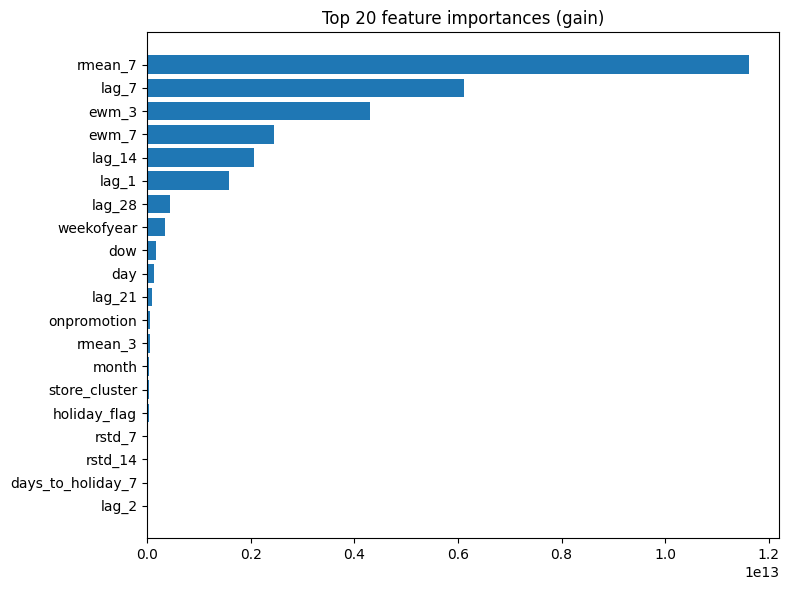

In [20]:
imp = pd.DataFrame({"feature": model.feature_name(), "gain": model.feature_importance("gain")})
imp = imp.sort_values("gain", ascending=False).reset_index(drop=True)
plt.figure(figsize=(8,6))
plt.barh(imp["feature"].head(20)[::-1], imp["gain"].head(20)[::-1])
plt.title("Top 20 feature importances (gain)")
plt.tight_layout()
plt.show()

## Predict on Test Set and Save Submission
* predict sales on test set
* fill missing prediction
* save submission to CSV

In [21]:
X_test = test_feat[features].copy()
preds_test = model.predict(X_test, num_iteration=model.best_iteration)
preds_test = np.clip(preds_test, 0, None)

test_feat["pred_sales"] = preds_test

# Merge back to original test
test_out = test.merge(test_feat[["unique_id","date","pred_sales"]], on=["unique_id","date"], how="left")
median_sales = train.groupby("unique_id")["sales"].median().to_dict()
test_out["sales"] = test_out.apply(lambda r: median_sales.get(r["unique_id"], 0.0) if pd.isna(r["pred_sales"]) else r["pred_sales"], axis=1)
test_out["sales"] = test_out["sales"].clip(lower=0.0)

submission = test_out[["id","sales"]].copy()
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv with", submission.shape[0], "rows")

Saved submission.csv with 28512 rows
